## Train autoencoder network
This notebook trains a convolutional autoencoder on the hdf5 dataset created by the syllable segmentation notebooks.
The trained model is then used to perform dimensionality reduction and generate novel stimuli
Import packages

### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline  
import os
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import hdbscan 
from datetime import datetime

/home/srrudrar/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/srrudrar/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/srrudrar/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/srrudrar/anaconda3/

In [3]:
from avgn.network_analysis.network_analysis import *
import avgn.network.convnet_model as conv
from avgn.network.training import *

In [4]:
import numpy as np
import glob

### Allocate GPUs

In [5]:
gpus = [1] # Here I set CUDA to only see one GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=','.join([str(i) for i in gpus])
num_gpus = len(gpus) # number of GPUs to use
if len(gpus) < 1:
    num_gpus = 1

In [6]:
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
print( [x.name for x in local_device_protos if x.device_type == 'GPU'] )

['/device:GPU:0']


### Define data parameters

In [37]:
dims = [100, 64, 1] # first dimension of input data
batch_size = 16 # size of batches to use (per GPU)

### Load dataset

In [8]:
# norm spec to 0-1
# break spec to 64 x 100 segments
# store in hdf5 with source wav name
mel_spec_folder = "/mnt/cube/srrudrar/datasets/mel_spectrograms/"
myfiles = glob.glob(r'/mnt/cube/srrudrar/datasets/mel_spectrograms/*.npy')

In [9]:
myfiles_20 = myfiles[0:20]

In [10]:
len(myfiles_20)

20

In [11]:
def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom 

from itertools import islice

def split_every(n, iterable):
    i = iter(iterable)
    piece = list(islice(i, n))
    while piece:
        yield piece
        piece = list(islice(i, n))

In [12]:
mel_spec_seg = []

In [13]:
for mymelspec in myfiles_20:
    mel_spec = np.load(mymelspec)
    mel_spec_scaled = scale(mel_spec, 0, 1)
    for part in split_every(100, np.transpose(mel_spec_scaled)):
        if np.shape(part)[0] == 100:
            mel_spec_seg.append(part)

In [16]:
num_examples = len(mel_spec_seg)
num_examples

3735

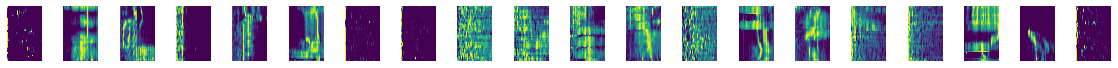

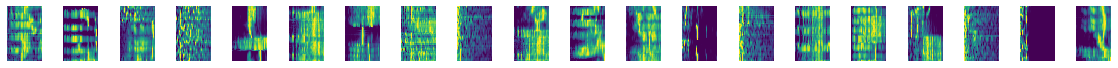

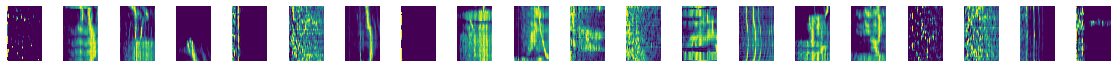

In [21]:
nex=20
for i in range(3):
    fig, ax = plt.subplots(nrows=1,ncols=nex, figsize=(nex,1))
    for i in range(nex):
        ax[i].matshow(np.array(mel_spec_seg[np.random.randint(num_examples)]),
                      cmap=plt.cm.viridis, interpolation='nearest', origin='lower')
        ax[i].axis('off')

#### Split dataset into training and validation sets 

In [23]:
val_pct = .1 # how much of the dataset to set aside for validation of reconstruction

In [27]:
validation_set = np.random.permutation(np.arange(len(mel_spec_seg)))[:int(len(mel_spec_seg)*val_pct)]
mask = np.ones(len(mel_spec_seg), np.bool)
mask[validation_set] = 0
validation_syllables = np.array(mel_spec_seg)[validation_set]
training_syllables = np.array(mel_spec_seg)[mask]
print(len(training_syllables), len(validation_syllables))

3362 373


### Define the network

#### Network dimensions 

In [32]:
# dimensions of network
# [depth, filter size, stride] # decoder will become inverse of encoder
encoder_dims = [
    [64, 3, 1],  # 64
    [64, 3, 2], # 64
    [128, 3, 1], # 64
    [64, 3, 2], # 32
    [128, 3, 1], # 32
    [64, 3, 2], # 16
    [128, 3, 1], # 16
    [2000, 0, 0], # 8
    [2000, 0, 0], # 8
]
decoder_dims = encoder_dims[::-1]
hidden_size = 2
latent_loss = 'distance' # Either 'None', 'distance', or 'VAE'

In [38]:
model = conv.ConvAE(dims, batch_size, encoder_dims, decoder_dims, hidden_size, latent_loss=latent_loss, 
                    network_type='AE', gpus=[0], adam_eps = 1.0e-8, activation_fn=tf.nn.relu) 
# eps = 0.1 and lr = 1 (after lr 0.1)

/home/srrudrar/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Encoder shapes:  [(16, 100, 64, 1), (16, 100, 64, 64), (16, 50, 32, 64), (16, 50, 32, 128), (16, 25, 16, 64), (16, 25, 16, 128), (16, 13, 8, 64), (16, 13312), (16, 2000), (16, 2000)]
Decoder shapes:  [(16, 2), (16, 2000), (16, 2000), (16, 16, 16, 128), (16, 32, 32, 128), (16, 32, 32, 128), (16, 64, 64, 128), (16, 64, 64, 128), (16, 128, 128, 128), (16, 128, 128, 64), (16, 100, 64, 64), (16, 100, 64, 1), (16, 6400)]
Network Initialized


### Train the model

In [39]:
# define a training iterator over your data
iter_ = data_iterator(training_syllables,y=None,batch_size=batch_size,num_gpus=num_gpus,dims=dims)

In [45]:
np.shape(training_syllables[10])
import matplotlib.pyplot as plt

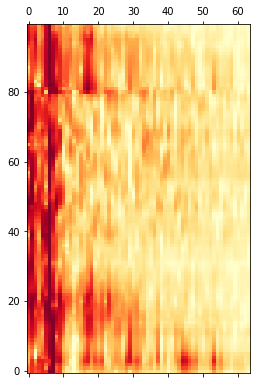

In [48]:
plt.matshow(training_syllables[1000], origin = 'lower', cmap = plt.cm.YlOrRd)
plt.show()

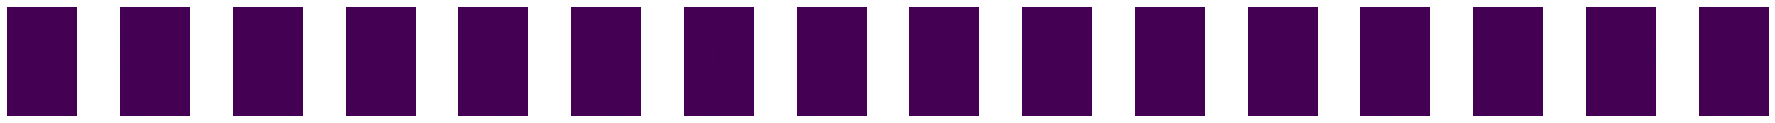

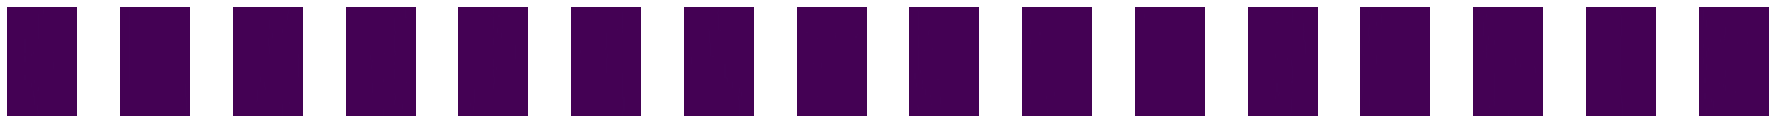

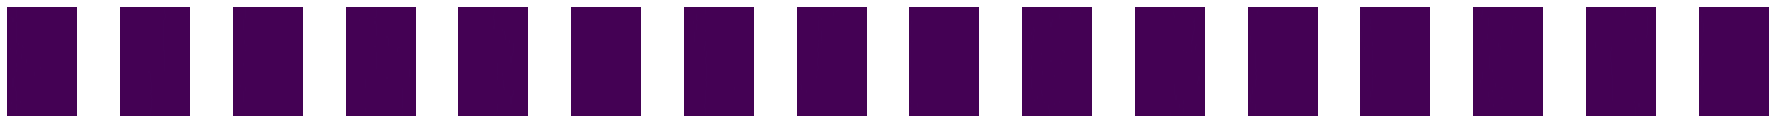

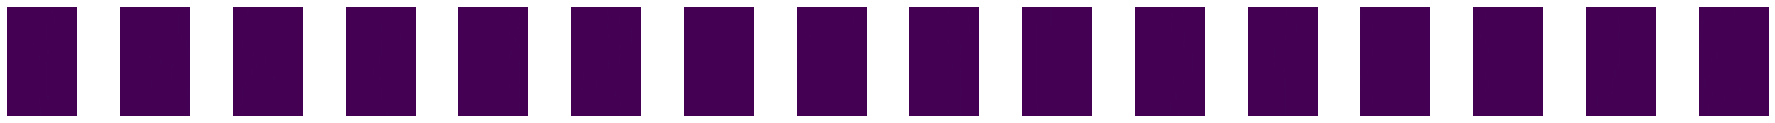

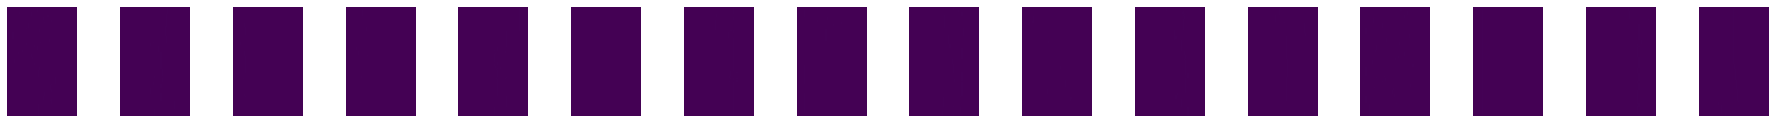

In [51]:
nex=16

for ii in range(5):
    example_data = iter_.__next__()[0]
    fig, ax = plt.subplots(nrows=1,ncols=nex, figsize=(nex*2,1*2))
    for i in range(nex):
        ax[i].matshow(example_data[i].reshape((dims[0],dims[1])), cmap=plt.cm.viridis, interpolation='nearest', origin='lower', vmin=0, vmax=1)
        ax[i].axis('off')
    plt.show()

#### train a single epoch to test

In [52]:
learning_rate = 1e-4
latent_loss_weights = 1e-1

In [53]:
# a list of which tensors to return from the network (e.g. train_D/G are necessary to train the network, losses are useful for plots)
return_list = ['train_D', 'train_E', 'L_d', 'L_e', 'recon_loss', 'distance_loss'] 
iter_ = data_iterator(training_syllables,y=None,batch_size=batch_size,num_gpus=num_gpus,dims=dims)
validation_iter_ = data_iterator(validation_syllables,y=None,batch_size=batch_size,num_gpus=num_gpus,dims=dims)

#train_AE(model, iter_,dataset_size = len(training_syllables), validation_iter_=False, learning_rate = 1.0, return_list=return_list)
training_df, validation_df = train_AE(model, iter_,dataset_size = int(len(training_syllables)/100), validation_iter_=validation_iter_,validation_size=len(validation_syllables),
                                      learning_rate = learning_rate, return_list=return_list, latent_loss_weights=latent_loss_weights)

In [54]:
training_df[:3]

,batch,train_D,train_E,L_d,L_e,recon_loss,distance_loss
0,1,None,None,0.249110,0.261059,0.249110,0.119483
1,2,None,None,0.248627,0.262469,0.248627,0.138423


### Train the network in full

In [68]:
from datetime import datetime

In [69]:
bird_name = 'example'
network_identifier = 'Distance_AE_'+bird_name
now_string = datetime.now().strftime("%Y-%m-%d_%H-%M-%S") # this is used to identify this training instance
print(now_string)

2020-03-28_13-15-45


In [70]:
### Parameters, etc...
num_epochs = 50 # how many epochs to train the network for
epoch = 0 # initialize epochs
save_loc = '/mnt/cube/srrudrar/avgn/data/models/'+network_identifier + '/'+now_string+'/'
print(save_loc)
# Visualizations (these only work if you choose a 2D latent space - write a new viz function if you didn't...)
network_save_epochs = np.unique(np.logspace(0,np.log2(num_epochs),num=20, base= 2).astype('int')) # (epochs) - which epochs to save the network
network_save_epochs=network_save_epochs[network_save_epochs>50]
#network_visualize_progress = np.unique(np.logspace(0,np.log2(num_epochs),num=10000, base= 2).astype('int')) # how often to visualize the network (leave empty list for never)
network_visualize_progress = np.arange(num_epochs)
img_save_loc = '/mnt/cube/srrudrar/avgn/img/'+network_identifier + '/'+now_string+'/'

/mnt/cube/srrudrar/avgn/data/models/Distance_AE_example/2020-03-28_13-15-45/


In [71]:
#model.load_network('../../../../data/models/Distance_AE_CAVI/2018-10-17_10-00-27/28_model.tfmod')

49


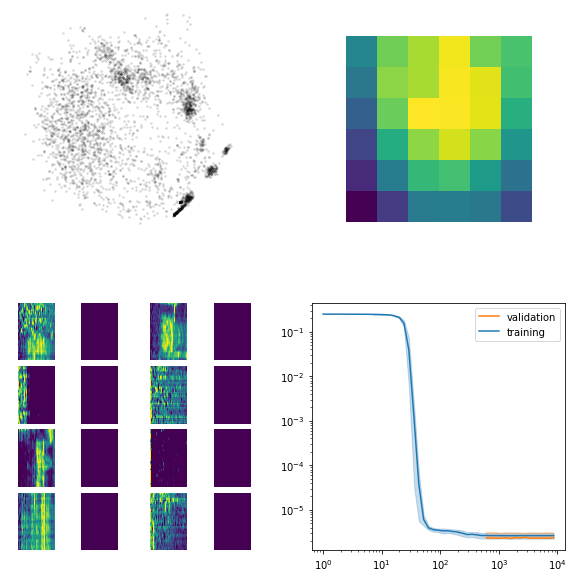

Network Saved



In [72]:
try:
    for epoch in tqdm(range(epoch,num_epochs)):
        
        
        # visualization
        if epoch in network_visualize_progress:
            clear_output()
            print(epoch)
            visualize_2D_AE(model, training_df, validation_df, example_data, num_examples,
                            batch_size, num_gpus, dims, iter_, n_cols = 4, std_to_plot = 2.5,
                            save_loc = img_save_loc+now_string+'/'+str(epoch)+'.png')
        
        # training
        iter_ = data_iterator(training_syllables,y=None,batch_size=batch_size,num_gpus=num_gpus,dims=dims)
        validation_iter_ = data_iterator(validation_syllables,y=None,batch_size=batch_size,num_gpus=num_gpus,dims=dims)
        training_df_epoch, validation_df_epoch = train_AE(model, iter_, dataset_size = len(training_syllables),
                                              validation_iter_=validation_iter_,validation_size=len(validation_syllables),
                                              learning_rate = learning_rate, return_list=return_list,
                                                         latent_loss_weights=latent_loss_weights)
        training_df = pd.concat([training_df, training_df_epoch])
        validation_df = pd.concat([validation_df, validation_df_epoch])
        
        # save network
        if epoch in network_visualize_progress:
            if not os.path.exists(save_loc):
                os.makedirs(save_loc) 
            model.save_network(save_loc+str(epoch)+'_model.tfmod')
        
except KeyboardInterrupt:
    print('interrupted by keyboard')

In [73]:
print(epoch)

49


In [74]:
### save this model
if not os.path.exists(save_loc+'manual/'):
    os.makedirs(save_loc+'manual/') 
model.save_network(save_loc+'manual/manual_model.tfmod')

Network Saved


### Translate syllables into latent space

In [124]:
def encode_x(x, z_shape,batch_size):
    nex =np.ceil(len(x)/batch_size).astype('int')
    face_z = np.zeros([nex*batch_size] + list(z_shape))
    face_x = np.zeros([nex*batch_size] + list(np.shape(x)[1:]))
    face_x[:len(x)] = x
    for batch in np.arange(nex):
        cur_batch = face_x[int(batch*batch_size):int((batch+1)*batch_size)]
        z_out = model.sess.run(model.z_x,{model.x_input: cur_batch})
        face_z[batch*batch_size:(batch+1)*batch_size,:] = z_out
    z_final = face_z[:len(x)]
    return z_final

def decode_z(z, x_shape, batch_size):
    nex =np.ceil(len(z)/batch_size).astype('int')
    face_x = np.zeros([nex*batch_size] + list(x_shape))
    face_z = np.zeros([nex*batch_size] + list(np.shape(z)[1:]))
    face_z[:len(z)] = z
    for batch in np.arange(nex):
        cur_batch = face_z[int(batch*batch_size):int((batch+1)*batch_size)]
        x_out = model.sess.run(model.x_tilde,{model.z_x: cur_batch})
        face_x[batch*batch_size:(batch+1)*batch_size,:] = x_out
    x_final = face_x[:len(z)]
    return x_final

In [77]:
x = np.array(mel_spec_seg)/255.
z = encode_x(np.reshape(x, (len(x), np.prod(np.shape(x)[1:]))), [hidden_size], model.batch_size)
print(np.shape(z))

(3735, 2)


In [111]:
x = np.array(mel_spec_seg)
z = encode_x(np.reshape(x, (len(x), np.prod(np.shape(x)[1:]))), [hidden_size], model.batch_size)
print(np.shape(z))

(3735, 2)


### Generate grid of vocalizations

In [112]:
np.min(z[:,0]), np.max(z[:,0]), np.min(z[:,1]), np.max(z[:,1])

(-8.006012916564941,
 -0.42178964614868164,
 2.29109525680542,
 10.373148918151855)

In [86]:
type(model)

avgn.network.convnet_model.ConvAE

(1000, 640)


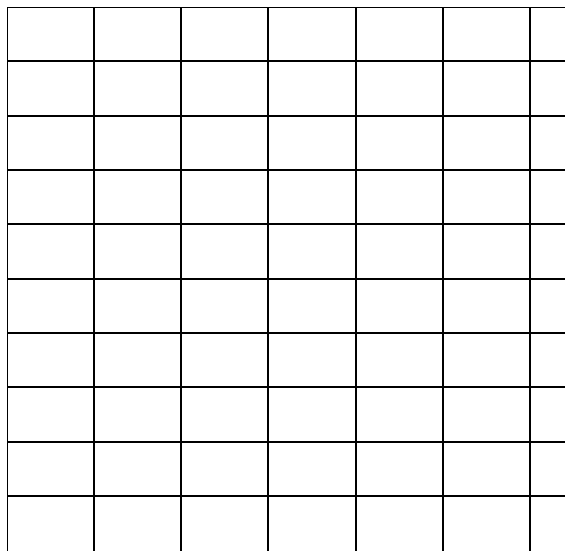

In [113]:
spacing = 5
xs = [-25, 25]
ys = [-125,-75]
xv,yv = draw_grid(model,dims,batch_size,xs,ys,spacing = spacing, zoom = 1)

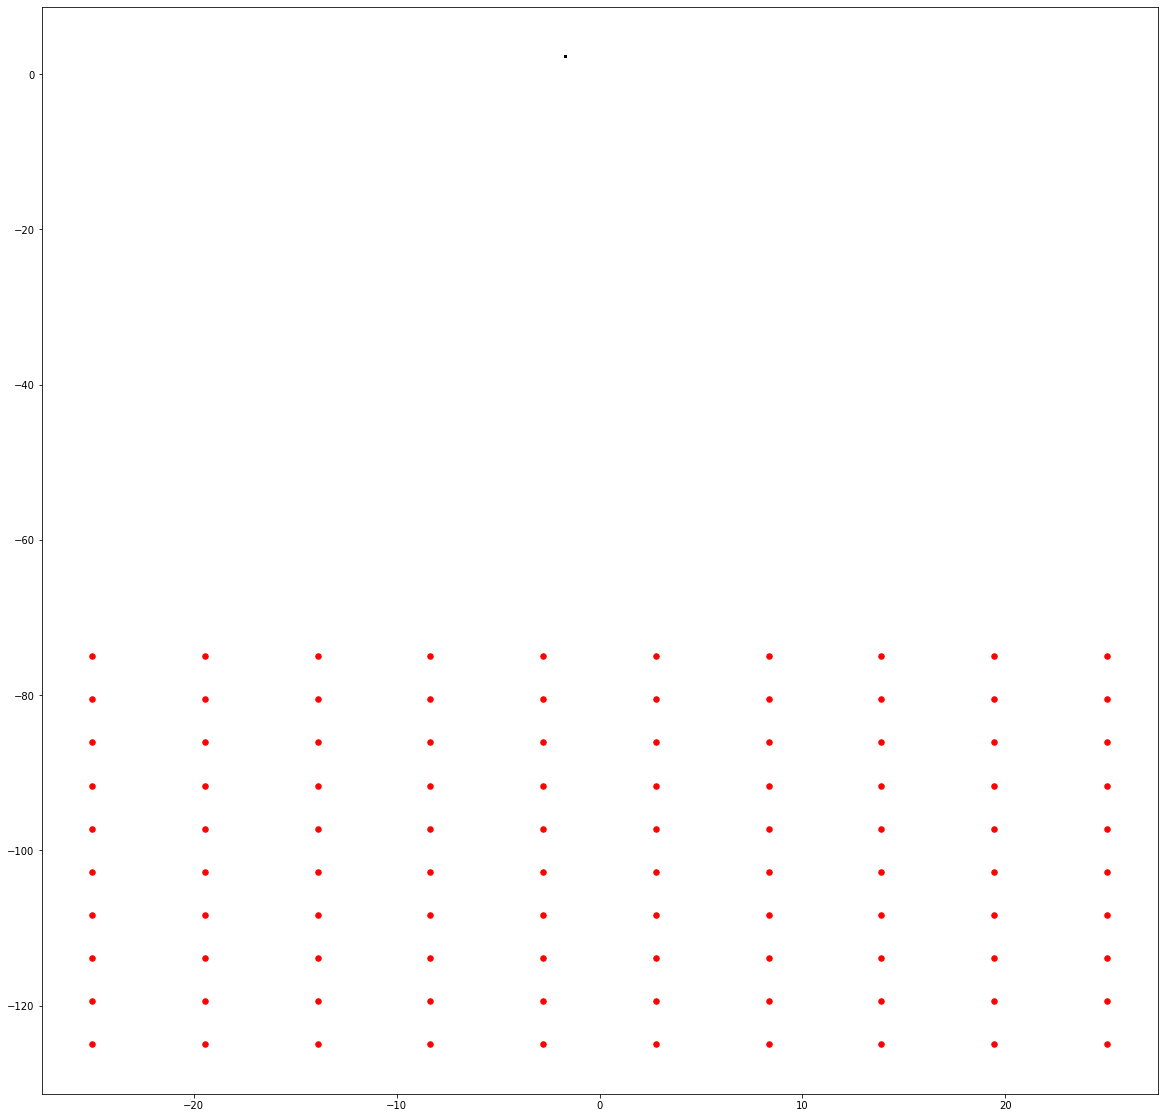

In [110]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,20))
ax.scatter(z[:,0], z[:,1], color='k', s=1)
ax.scatter(xv, yv, color='r', s=30)
#ax.axis('off')
plt.show()

In [115]:
pt1 = 550; pt2 = 100
syllable_1 = mel_spec_seg[pt1]
syllable_2= mel_spec_seg[pt2]

(-0.5, 63.5, -0.5, 99.5)

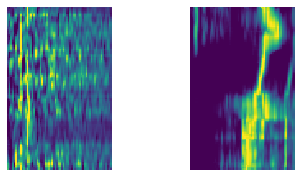

In [116]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(6,3))
ax[0].matshow(syllable_1, origin = 'lower'); ax[0].axis('off')
ax[1].matshow(syllable_2, origin = 'lower'); ax[1].axis('off')

In [118]:
n_frames_per_interp = 32 # how many points in interp.
z1 = encode_x(np.array([np.array(syllable_1).flatten()/255.]), [2], batch_size)[0]
z2 = encode_x(np.array([np.array(syllable_2).flatten()/255.]), [2], batch_size)[0]

In [119]:
pcts = np.linspace(0,1,n_frames_per_interp+1)[:-1]

In [122]:
[np.prod(dims[:-1])]

[6400]

In [123]:
x1_interp = decode_z(z1, [100,64], batch_size)

ValueError: Cannot feed value of shape (16,) for Tensor 'enc/latent_layer/BiasAdd:0', which has shape '(16, 2)'

In [87]:
spacing = 5
xs = [-25, 25]
ys = [-125,-75]

In [88]:
x = np.linspace(xs[0],xs[1], np.abs(xs[1]-xs[0])/spacing)
y = np.linspace(ys[0],ys[1], np.abs(ys[1]-ys[0])/spacing)
xv, yv = np.meshgrid(x, y)

In [89]:
def generate_specs_from_z_path(model, z_path, dims, batch_size):
    num_batches = int(np.ceil(float(len(z_path))/batch_size))
    all_x = np.zeros((len(z_path), dims[0]*dims[1]))
    for batch in range(num_batches):
        batch_input = np.zeros((batch_size, 2))
        batch_to_enter = z_path[batch*batch_size:(batch+1)*batch_size]
        batch_input[:len(batch_to_enter), :] = batch_to_enter
        all_x[batch*batch_size:(batch*batch_size)+len(batch_to_enter)] = model.sess.run((model.x_tilde), {model.z_x: batch_input})[:len(batch_to_enter)]
    return all_x

In [90]:
spectrograms_list = generate_specs_from_z_path(model,np.stack((np.ndarray.flatten(xv), np.ndarray.flatten(yv))).T, dims, batch_size)

In [93]:
spectrograms_list = np.reshape(spectrograms_list,(len(spectrograms_list), dims[0], dims[1]))
spectrograms_list = np.reshape(spectrograms_list,tuple(list(np.shape(xv)) + [dims[0]] + [dims[1]]))

In [94]:
x_len = np.shape(spectrograms_list)[0]
y_len = np.shape(spectrograms_list)[1]

In [95]:
x_len, y_len

(10, 10)

In [98]:
canvas = np.zeros((x_len*dims[0], y_len*dims[1]))

print(np.shape(canvas))
zoom = 1

(1000, 640)


In [104]:
np.shape(np.flipud(spectrograms_list[6,5,:,:]))

(100, 64)

In [107]:
np.flipud(spectrograms_list[6,5,:,:])[2,2]

0.0

In [108]:
np.flipud([1,2])

array([2, 1])

In [ ]:
canvas[6*dims[1]:(6+1)*dims[1],i*dims[0]:(i+1)*dims[0]]

In [105]:
dims[1]

64

ValueError: could not broadcast input array from shape (100,64) into shape (64,100)

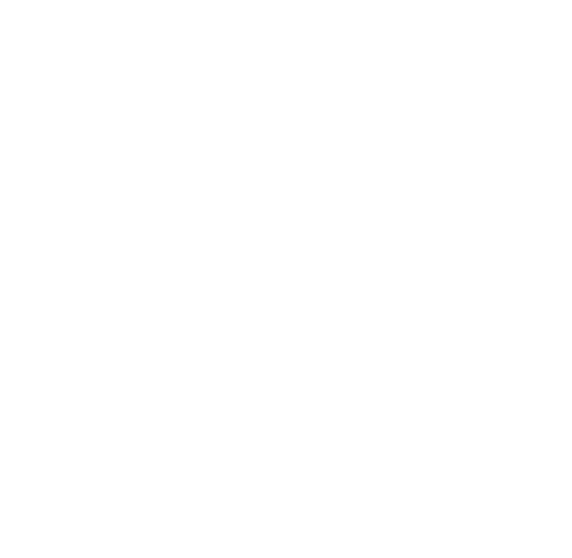

In [100]:
fig_spc, ax_spc = plt.subplots(figsize=(y_len*zoom,x_len*zoom))
ax_spc.axis('off')

for i in range(y_len):
    for j in range(x_len):
        canvas[j*dims[1]:(j+1)*dims[1],i*dims[0]:(i+1)*dims[0]] =np.flipud(spectrograms_list[j,i,:,:])
        if (i ==0) : ax_spc.axhline(j*dims[0]-1, color='k', lw=2)
    ax_spc.axvline(i*dims[0]-1, color='k', lw=2)
#ax_spc.axhline((j+1)*dims[0]-2, color='k', lw=4)
#ax_spc.axvline((i+1)*dims[0]-2, color='k', lw=4)
[j.set_linewidth(2) for j in ax_spc.spines.values()]
[j.set_edgecolor('k') for j in ax_spc.spines.values()]

ax_spc.matshow(canvas, cmap=plt.cm.Greys, interpolation='nearest', aspect='auto')
plt.setp( ax_spc.get_xticklabels(), visible=False)
plt.setp( ax_spc.get_yticklabels(), visible=False)
plt.show()


In [ ]:
x = np.linspace(xs[0],xs[1], np.abs(xs[1]-xs[0])/spacing)
y = np.linspace(ys[0],ys[1], np.abs(ys[1]-ys[0])/spacing)
xv, yv = np.meshgrid(x, y)
#
spectrograms_list = generate_specs_from_z_path(model,np.stack((np.ndarray.flatten(xv), np.ndarray.flatten(yv))).T, dims, batch_size)
spectrograms_list = np.reshape(spectrograms_list,(len(spectrograms_list), dims[0], dims[1]))
spectrograms_list = np.reshape(spectrograms_list,tuple(list(np.shape(xv)) + [dims[0]] + [dims[1]]))
x_len = np.shape(spectrograms_list)[0]
y_len = np.shape(spectrograms_list)[1]
canvas = np.zeros((x_len*dims[0], y_len*dims[1]))
fig_spc, ax_spc = plt.subplots(figsize=(y_len*zoom,x_len*zoom))
ax_spc.axis('off')


print(np.shape(canvas))
zoom = 1
for i in range(y_len):
    for j in range(x_len):
        canvas[j*dims[1]:(j+1)*dims[1],i*dims[0]:(i+1)*dims[0]] =np.flipud(spectrograms_list[j,i,:,:])
        if (i ==0) : ax_spc.axhline(j*dims[0]-1, color='k', lw=2)
    ax_spc.axvline(i*dims[0]-1, color='k', lw=2)
#ax_spc.axhline((j+1)*dims[0]-2, color='k', lw=4)
#ax_spc.axvline((i+1)*dims[0]-2, color='k', lw=4)
[j.set_linewidth(2) for j in ax_spc.spines.values()]
[j.set_edgecolor('k') for j in ax_spc.spines.values()]

ax_spc.matshow(canvas, cmap=plt.cm.Greys, interpolation='nearest', aspect='auto')
plt.setp( ax_spc.get_xticklabels(), visible=False)
plt.setp( ax_spc.get_yticklabels(), visible=False)
plt.show()
# save figure
if savefig:
    if not os.path.exists('../../data/imgs/interpolation/'+species+'/'):
        os.makedirs('../../data/imgs/interpolation/'+species+'/')
        #extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig_spc.savefig('../../data/imgs/interpolation/'+species+'/'+bird+'_indv.png', bbox_inches='tight', transparent=True)
return xv, yv